In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from torchvision.transforms import functional as TF
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Image as IPImage

from wiring_efficiency_utils import *
from neuralsheet import *
from map_plotting import *

%load_ext autoreload
%autoreload 2

In [844]:
# Example usage
crop_size = 50  # Crop size (NxN)
batch_size = 64  # Number of crops to load at once
num_workers = 4  # Number of threads for data loading
root_dir = './input_stimuli'  # Path to your image folder
device = 'cuda'  # Assuming CUDA is available and desired
M = 42  # Neural sheet dimensions
std_exc = 1 # Standard deviation for excitation Gaussian
std_rfs = 6
epochs = 100

dataloader = create_dataloader(root_dir, crop_size, batch_size, num_workers)
model = NeuralSheet(M, crop_size, std_exc, std_rfs, device=device).to(device)
rf_grids = get_grids(crop_size, crop_size, model.rf_size, M, device=device)

In [845]:
lr = 1e-3
model.homeo_lr = 1e-3
beta = 1 - 5e-5
network = init_nn(M, crop_size)
dataloader = create_dataloader(root_dir, crop_size, batch_size, num_workers)
avg_loss = 0
loss_beta = 1e-2

dict_keys([0, 1, 2, 3, 4])


In [ ]:
# Looping over the DataLoader
# network = init_nn(M, crop_size)
#lr = 5e-4
#model.homeo_lr = lr

for e in range(epochs):

    batch_progress = tqdm(dataloader, leave=False)
    for batch in batch_progress:

        batch_responses = []
        batch_inputs = []
        batch = batch.to('cuda')  # Transfer the entire batch to GPU
        
        for image in batch:

            image = image[:1][None].flip(1)
            
            if image.mean()>0.15:

                lr *= beta
                lr = lr if lr>5e-5 else 5e-5
                model.hebbian_lr = lr

                model.homeo_lr *= beta
                model.homeo_lr = model.homeo_lr if model.homeo_lr>5e-5 else 5e-5

                model(image, rf_grids)
                model.hebbian_step()

                batch_responses.append(model.current_response.clone())
                batch_inputs.append(model.current_input.clone())

        batch_responses = torch.cat(batch_responses, dim=0)
        batch_inputs = torch.cat(batch_inputs, dim=0)
        
        reco_input = network['activ'](network['model'](batch_responses))
        loss_weights = batch_responses.sum([1,2,3]) 
        loss_weights /= loss_weights.sum()
        loss = nn_loss(network, batch_inputs[:,0][:,None], reco_input, 1/batch_responses.shape[0])

        avg_loss = (1-loss_beta)*avg_loss + loss_beta*loss
        
        network['optim'].zero_grad()
        loss.backward()
        network['optim'].step()

        mean_activation = model.mean_activations.mean()
        mean_std = model.mean_activations.std() / model.homeo_target
        batch_progress.set_description('Mean acts: {:.3f}, STD: {:.3f}, Reco: {:.0f}, LR: {:.5f}'.format(
            mean_activation, 
            mean_std, 
            avg_loss, 
            lr
        ))

        

Mean acts: 0.042, STD: 0.162, Reco: 254, LR: 0.00071:  18%|▏| 110/604 [04:39<20:

In [ ]:
log_std = 6
log_size = oddenise(5*log_std)
model.contrast_log = - get_log(log_size, log_std).to('cuda')

Net Afferent Max: 0.416, Net Afferent Min: -0.130
Mean Act Max: 0.075, Mean Act Min: 0.013
Thresholds Max: 0.382, Thresholds Min: -0.140
L4 Thresholds Max: 0.927, L4 Thresholds Min: 0.217
Mean thresholds: -0.018 and mean OFF strength 1.000
Mean pos afferent Mean: 0.000 and aff strength 2.000
Mean current response: 0.071
L4 Strength: 2.400 strength: 2.983 aff strength: 2.000


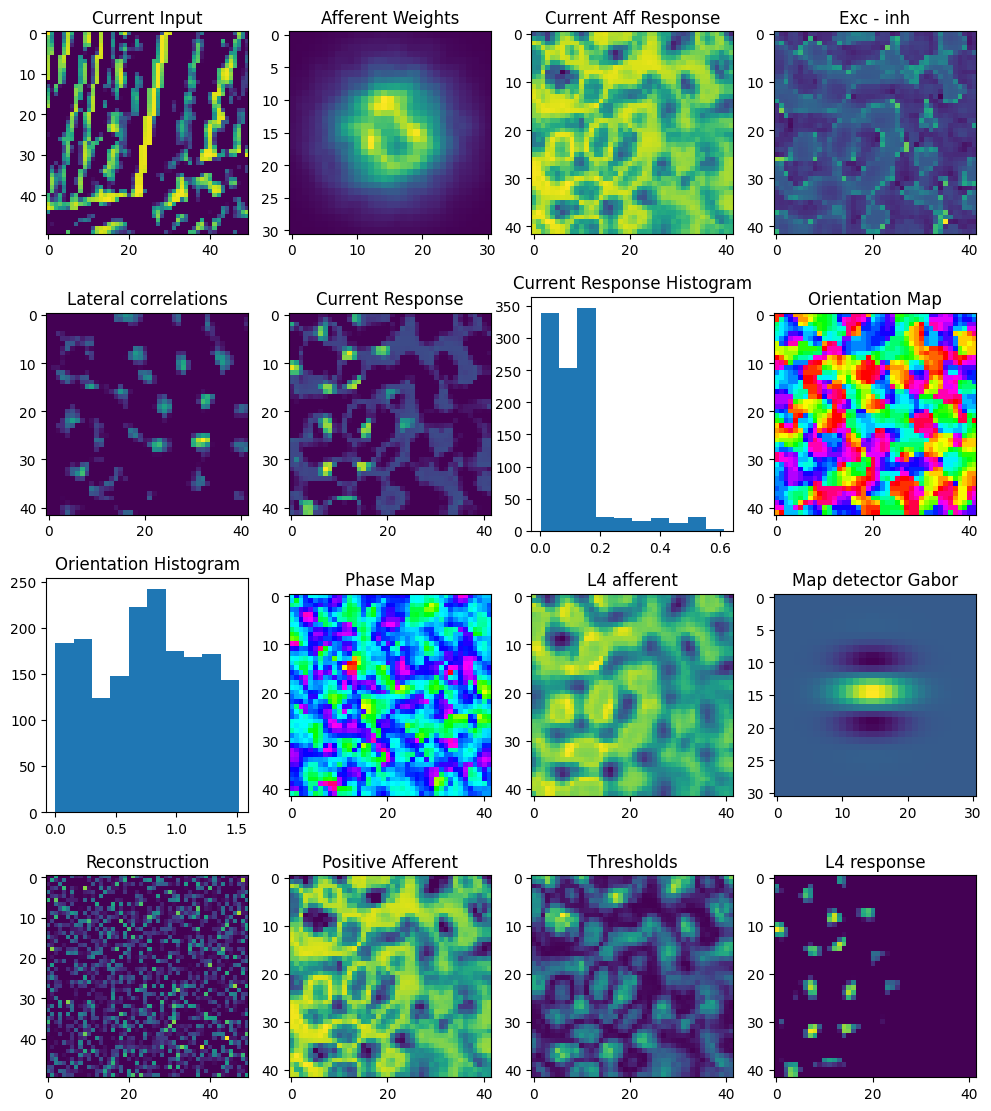

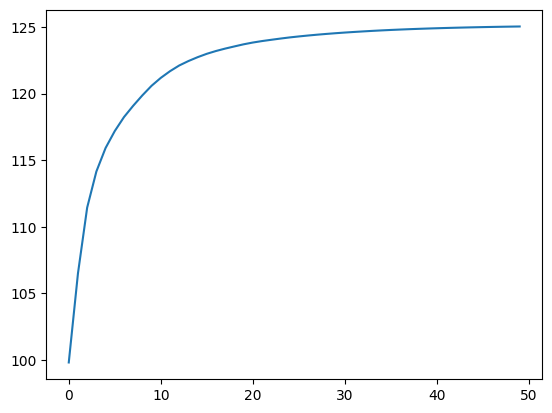

In [842]:
%matplotlib inline

random_sample = random.randint(0, model.afferent_weights.shape[0] - 1)
random_batch = random.randint(0, batch.shape[0] - 1)
model(batch[random_batch, :1][None].flip(1), rf_grids)
show_map(model, network, random_sample)
model.current_response.max()
array = model.response_tracker.cpu()[:,0]
array[:,0,0] = 1
anim = animate(array, model.iterations)

plt.plot(model.response_tracker[:model.iterations].sum([1,2,3]).cpu())
anim

In [160]:
#plt.imshow(get_orientations(model.afferent_weights)[0].cpu().view(80,80), cmap='hsv')

In [438]:
%matplotlib widget
sample = np.random.randint(0, model.sheet_size**2)
sample = 2200
x = np.linspace(-1, 1, M)
y = np.linspace(-1, 1, M)
x, y = np.meshgrid(x, y)
z = model.lateral_correlations[sample,0].cpu() #* model.masks[sample,0].cpu()
#z = z*model.eq + model.untuned_inh[sample,0].cpu()*(1-model.eq)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')


ax.plot_surface(x, y, z, cmap='viridis', edgecolor='none', rstride=1, cstride=1, alpha=1)
plt.show()

IndexError: index 2200 is out of bounds for dimension 0 with size 1024

<Figure size 640x480 with 0 Axes>

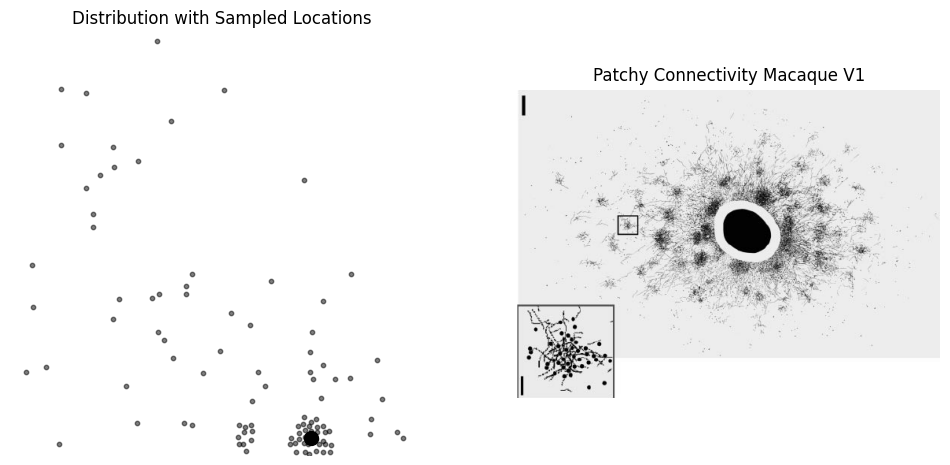

In [582]:
plt.clf()
%matplotlib inline

num_samples = 100   # Number of samples you want to draw
theta = 0

# Assuming model.sheet_size and M are defined elsewhere
# model.sheet_size = ...  
M = model.sheet_size

sample_idx = np.random.randint(0, model.sheet_size**2)
z = model.lateral_correlations[sample_idx, 0].cpu()

# Generate an example distribution (MxM)
# This could be your actual distribution, ensure it sums to 1 if it represents probabilities
distribution = torch.relu(z - theta)
distribution /= distribution.sum()

sample_and_plot(distribution, num_samples, sample_idx)

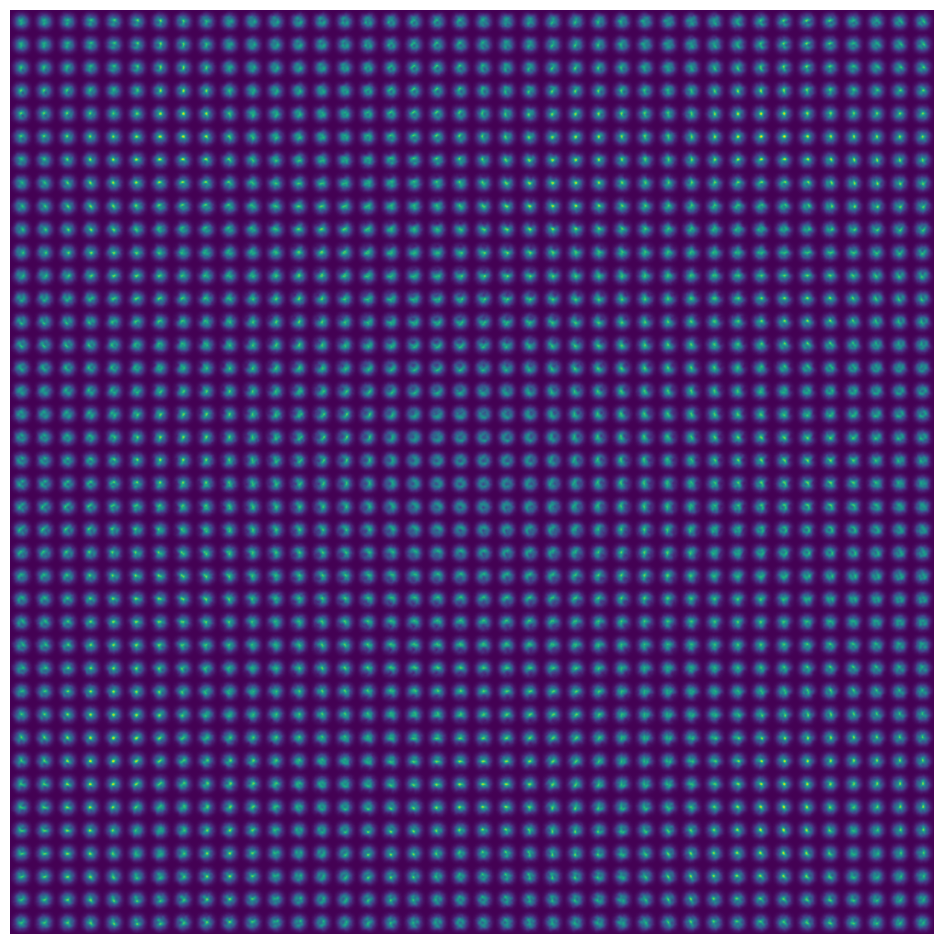

In [434]:
%matplotlib inline
angles = model.afferent_weights.cpu()
angles = angles.view(M, M, model.rf_size, model.rf_size)
angles = angles.permute(0,2,1,3).reshape(M*model.rf_size, M*model.rf_size)
plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(angles)

In [399]:
state = {

    'afferent' : model.afferent_weights,
    'lateral' : model.lateral_correlations
    
}

In [400]:
torch.save(state, 'state.pt')

In [4]:
state = torch.load('state.pt')
model.afferent_weights = state['afferent']
model.lateral_correlations = state['lateral']